**Name:** Jay Bharambe

**Roll No:** 22159

**GitHub:** https://github.com/jayb71/nlpassignment3

Note- Need to change the runtime type to T4-GPU, normal CPUs take exceptionally large time.

In [1]:
!pip install gensim

In [2]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt


In [3]:

!git clone https://github.com/islnlp/Assignment_1_2025 datasets


Cloning into 'datasets'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.06 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
base_github_url = "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master"

In [5]:
def generate_word2vec_embeddings(task, data_path="datasets", output_path="."):
    train_df = pd.read_csv(f"{data_path}/{task}/train.csv")
    sentences = train_df["Sentence"].apply(lambda x: x.split()).tolist()

    model = Word2Vec(sentences=sentences, vector_size=100, window=2, min_count=1, sg=1, epochs=10)

    word_vectors = model.wv
    vectors = np.array([word_vectors[word] for word in word_vectors.index_to_key])
    np.save(f"{output_path}/word_embeddings_{task}_1.npy", vectors)
    word_vectors.save(f"{output_path}/word2vec_{task}.kv")
    model.save(f"{output_path}/word2vec_{task}_model.model")

# save embeddings for each task
for task in ["hate", "humor", "sarcasm"]:
    generate_word2vec_embeddings(task)


In [6]:
def sentence_embedding(sentence, word_to_index, word_embeddings, max_len=50):
    words = sentence.split()
    valid_embeddings = [word_embeddings[word_to_index[word]] for word in words if word in word_to_index]
    if len(valid_embeddings) == 0:
        return np.zeros((max_len, word_embeddings.shape[1]))
    if len(valid_embeddings) > max_len:
        valid_embeddings = valid_embeddings[:max_len]
    else:
        padding = [np.zeros(word_embeddings.shape[1])] * (max_len - len(valid_embeddings))
        valid_embeddings.extend(padding)
    return np.array(valid_embeddings)

class TextDataset(Dataset):
    def __init__(self, data, word_to_index, word_embeddings, max_len=50):
        self.sentences = data["Sentence"].tolist()
        self.labels = data["Tag"].tolist()
        self.word_to_index = word_to_index
        self.word_embeddings = word_embeddings
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence_vector = sentence_embedding(self.sentences[idx], self.word_to_index, self.word_embeddings, self.max_len)
        label = self.labels[idx]
        return torch.tensor(sentence_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [7]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * 50, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, bidirectional=False):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        _, hidden = self.rnn(x)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=4, num_layers=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        x = self.encoder(x).mean(dim=0)
        return self.fc(self.dropout(x))

class BERTClassifier(nn.Module):
    def __init__(self, output_dim=2):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # 🔒 Freeze all BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

        # 🔄 Only train this classifier head
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Still allows gradient flow through classifier
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        return self.fc(pooled)


In [8]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):  # BERT
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, mask)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return acc, prec, rec, f1

class BERTDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.sentences = data["Sentence"].tolist()
        self.labels = data["Tag"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.sentences)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.sentences[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

def run_all_models(task):
    train_df = pd.read_csv(f"datasets/{task}/train.csv")
    val_df = pd.read_csv(f"datasets/{task}/val.csv")

    word_embeddings = np.load(f"word_embeddings_{task}_1.npy")
    word_vectors = KeyedVectors.load(f"word2vec_{task}.kv", mmap='r')
    word_to_index = {word: i for i, word in enumerate(word_vectors.index_to_key)}

    train_ds = TextDataset(train_df, word_to_index, word_embeddings)
    val_ds = TextDataset(val_df, word_to_index, word_embeddings)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    output_dim = len(set(train_df["Tag"]))
    models = {
        "FFNN": FFNN(100, 64, output_dim),
        "RNN": RNNClassifier(100, 64, output_dim),
        "LSTM": LSTMClassifier(100, 64, output_dim),
        "Bi-LSTM": LSTMClassifier(100, 64, output_dim, bidirectional=True),
        "Transformer": TransformerClassifier(100, 64, output_dim)
    }

    results = {}
    for name, model in models.items():
        model.to(device)
        # Training part and also saving the weights
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        # for epoch in range(5):  # training loop
        #     model.train()
        #     for x, y in train_loader:
        #         x, y = x.to(device), y.to(device)
        #         optimizer.zero_grad()
        #         loss = criterion(model(x), y)
        #         loss.backward()
        #         optimizer.step()
        # torch.save(model.state_dict(), f"{task}_{name}.pth")

        # # Load trained weights:
        # model.load_state_dict(torch.load(f"{task}_{name}.pth", map_location=device))

        url = f"{base_github_url}/{task}_{name}.pth"
        model.load_state_dict(torch.hub.load_state_dict_from_url(url, map_location=device))
        results[name] = dict(zip(["Accuracy", "Precision", "Recall", "F1"],
                                 evaluate_model(model, val_loader, device)))

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BERTClassifier(output_dim=output_dim).to(device)
    val_bert_loader = DataLoader(BERTDataset(val_df, tokenizer), batch_size=32)

    # BERT model Training
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_bert_loader = DataLoader(BERTDataset(train_df, tokenizer), batch_size=32, shuffle=True)
    bert_model = BERTClassifier(output_dim=output_dim).to(device)
    optimizer = optim.Adam(bert_model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # for epoch in range(3):
    #     bert_model.train()
    #     total_loss = 0
    #     for batch in train_bert_loader:
    #         input_ids = batch['input_ids'].to(device)
    #         mask = batch['attention_mask'].to(device)
    #         labels = batch['label'].to(device)

    #         optimizer.zero_grad()
    #         outputs = bert_model(input_ids, mask)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    #         total_loss += loss.item()
    #     print(f"[BERT Epoch {epoch+1}] Loss: {total_loss:.4f}")

    # torch.save(bert_model.fc.state_dict(), f"{task}_BERT.pth")

    # bert_model.fc.load_state_dict(torch.load(f"{task}_BERT.pth", map_location=device))

    url = f"{base_github_url}/{task}_BERT.pth"
    bert_model.fc.load_state_dict(torch.hub.load_state_dict_from_url(url, map_location=device))
    results["BERT"] = dict(zip(["Accuracy", "Precision", "Recall", "F1"],
                               evaluate_model(bert_model, val_bert_loader, device)))
    return results

# Run this for each task
all_results = {task: run_all_models(task) for task in ["hate", "humor", "sarcasm"]}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/hate_FFNN.pth" to /root/.cache/torch/hub/checkpoints/hate_FFNN.pth
100%|██████████| 1.22M/1.22M [00:00<00:00, 126MB/s]
Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/hate_RNN.pth" to /root/.cache/torch/hub/checkpoints/hate_RNN.pth
100%|██████████| 44.0k/44.0k [00:00<00:00, 60.7MB/s]
Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/hate_LSTM.pth" to /root/.cache/torch/hub/checkpoints/hate_LSTM.pth
100%|██████████| 169k/169k [00:00<00:00, 54.5MB/s]
Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/hate_Bi-LSTM.pth" to /root/.cache/torch/hub/checkpoints/h

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/hate_BERT.pth" to /root/.cache/torch/hub/checkpoints/hate_BERT.pth
100%|██████████| 7.47k/7.47k [00:00<00:00, 12.3MB/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Downloading: "https://github.com/jayb71/nlpassignment3/raw/refs/heads/master/humor_FFNN.pth" to /root/.cache/torch/hub/checkpoints/humor_FFNN.pth
100%|██████████| 1.22M/1.22M [00:00<00:00, 149MB/s]
Download

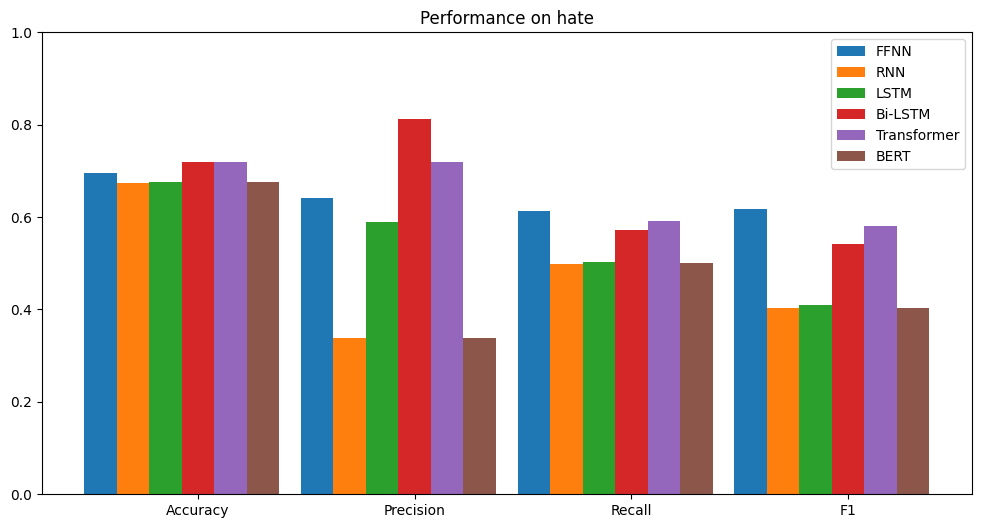

             Accuracy  Precision    Recall        F1
FFNN         0.695842   0.641901  0.613137  0.618281
RNN          0.673961   0.337719  0.498382  0.402614
LSTM         0.676149   0.588462  0.501760  0.409808
Bi-LSTM      0.719912   0.812837  0.571088  0.541654
Transformer  0.719912   0.718793  0.590451  0.581214
BERT         0.676149   0.338074  0.500000  0.403394


In [10]:
def plot_results(results, task):
    models = list(results.keys())
    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    x = np.arange(len(metrics))
    width = 0.15

    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        values = [results[model][m] for m in metrics]
        plt.bar(x + i * width, values, width, label=model)

    plt.xticks(x + width * (len(models) / 2), metrics)
    plt.ylim(0, 1)
    plt.title(f"Performance on {task}")
    plt.legend()
    plt.show()

plot_results(all_results["hate"], "hate")
print(pd.DataFrame(all_results["hate"]).T)


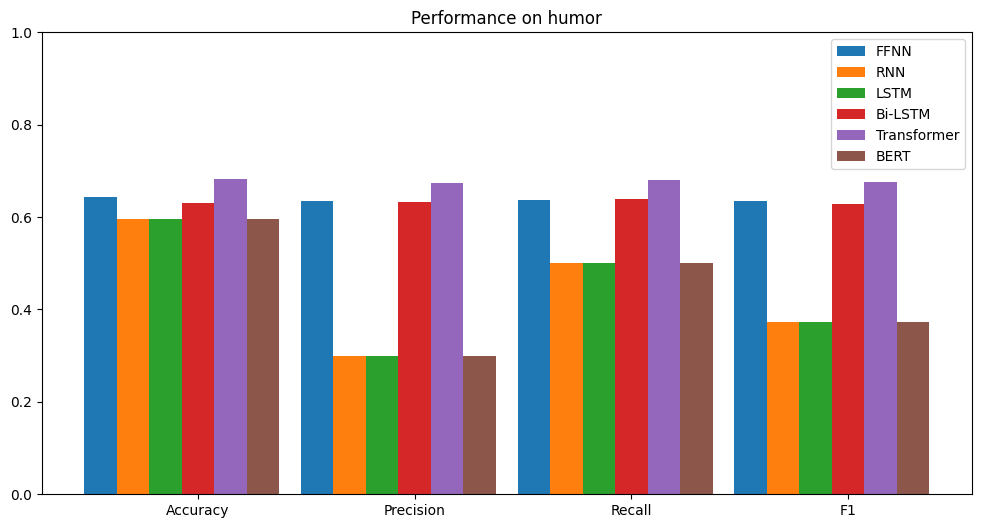

             Accuracy  Precision    Recall        F1
FFNN         0.644068   0.634499  0.637748  0.635198
RNN          0.596610   0.298305  0.500000  0.373673
LSTM         0.596610   0.298305  0.500000  0.373673
Bi-LSTM      0.630508   0.633580  0.638632  0.628047
Transformer  0.681356   0.674421  0.679884  0.675080
BERT         0.596610   0.298305  0.500000  0.373673


In [11]:
plot_results(all_results["humor"], "humor")
print(pd.DataFrame(all_results["humor"]).T)

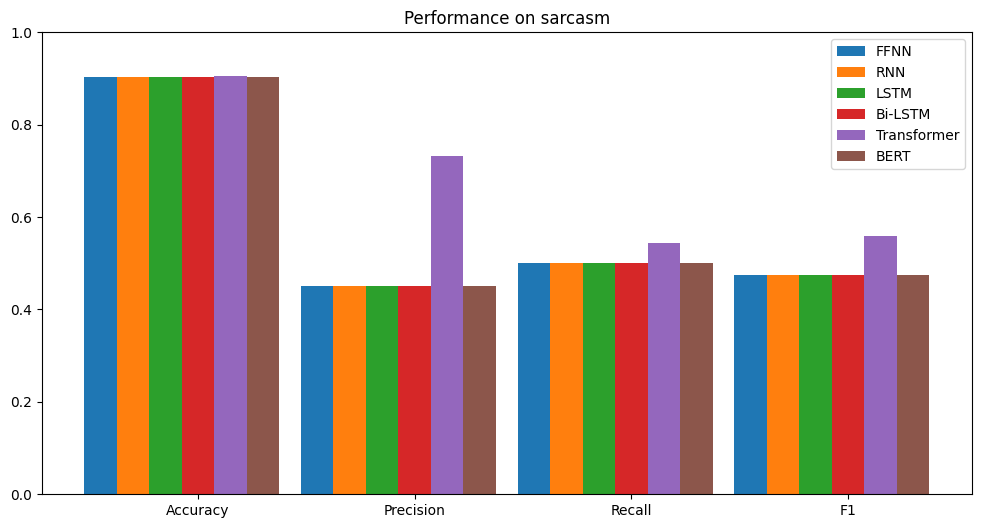

             Accuracy  Precision  Recall        F1
FFNN         0.902857   0.451429  0.5000  0.474474
RNN          0.902857   0.451429  0.5000  0.474474
LSTM         0.902857   0.451429  0.5000  0.474474
Bi-LSTM      0.902857   0.451429  0.5000  0.474474
Transformer  0.904762   0.733204  0.5448  0.558081
BERT         0.902857   0.451429  0.5000  0.474474


In [12]:
plot_results(all_results["sarcasm"], "sarcasm")
print(pd.DataFrame(all_results["sarcasm"]).T)